In [2]:
import numpy as np
from tensorflow import keras

In [5]:
data_path = "fra.txt"
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.

In [6]:
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n") # to separate each sentence
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split("\t")
    # the data is given such that English + TAB + The Other Language + TAB + Attribution
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = "\t" + target_text + "\n"
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

#integer encoding 
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])


Number of samples: 10000
Number of unique input tokens: 70
Number of unique output tokens: 93
Max sequence length for inputs: 14
Max sequence length for outputs: 59


In [4]:
print(input_texts[2781])
print(input_characters)
print(target_characters)
print(input_token_index)
print(target_token_index)

You called?
[' ', '!', '"', '$', '%', '&', "'", ',', '-', '.', '0', '1', '2', '3', '5', '7', '8', '9', ':', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
['\t', '\n', ' ', '!', '%', '&', "'", '(', ')', ',', '-', '.', '0', '1', '2', '3', '5', '8', '9', ':', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '\xa0', '«', '»', 'À', 'Ç', 'É', 'Ê', 'à', 'â', 'ç', 'è', 'é', 'ê', 'î', 'ï', 'ô', 'ù', 'û', 'œ', '\u2009', '’', '\u202f']
{' ': 0, '!': 1, '"': 2, '$': 3, '%': 4, '&': 5, "'": 6, ',': 7, '-': 8, '.': 9, '0': 10, '1': 11, '2': 12, '3': 13, '5': 14, '7': 15, '8': 16, '9': 17, ':'

In [5]:
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype="float32",
)
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype="float32",
)
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype="float32",
)

# one hot encoding of input output characters of sentence
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        # reads each sentence character by character and corresponding to that char in dictionary 1 is placed
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    # t can go till max sentence length so rest are mapped to integer corresponding to " "
    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
    # as decoder_target_data only t - 1 are labelled
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0

- np.zeroes dimension : (depth, height, width) -> (total sentences, maximum sentence length, vocabulary characters), to make equal number of chars in each sentence<br>
- encoder_input_data : 3d tensor consisting of each character from vocalbulary as one hot encoded on order of appearance in the sentence<br>
- decoder_input_data : similar to encoder_input_data, provided as input to the decoder consists of start of seq '\t' and end of seq '\n' and then blank spaces<br>
- decoder_target_data : one time step ahead of decoder_input_data, doesn't contain start of seq only end of seq '\n' and then blank spaces

In [6]:
print(encoder_input_data[0][0])
print(input_texts[0])
print(target_texts[0])
print(decoder_input_data[0][0])
print(decoder_target_data[0][0])
print(encoder_input_data.shape, decoder_input_data.shape, decoder_target_data.shape)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Go.
	Va !

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(10000, 14, 70) (10000, 59, 93) (10000, 59, 93)


- English Input example : Go.<br>
- enocder_input_data : dictionary character corresponding to G is 1 everything else is zero for encoder_input_data[0][0]<br>
- French Translated : /t Va !<br>
- decoder_input_data : dictionary character corresponding to /t as it is the start of the sequence character<br>
- decoder_target_data : dictionary character corresponding to V as the decoder target doesn't need start of seq char

<br>

Here Functional API for Keras is used : <br>
- https://machinelearningmastery.com/keras-functional-api-deep-learning/<br>
- https://keras.io/guides/functional_api/<br>
Relevant articles :
- https://machinelearningmastery.com/develop-encoder-decoder-model-sequence-sequence-prediction-keras/<br>
- https://machinelearningmastery.com/return-sequences-and-return-states-for-lstms-in-keras/<br>
- https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html<br>

In [ ]:
# Define an input sequence and process it.
# keras.Input should have been shape = (max sentence length, features or unique chars) but None indicates sequence can be of variable length
encoder_inputs = keras.Input(shape=(None, num_encoder_tokens)) 
encoder = keras.layers.LSTM(latent_dim, return_state=True) # return_state = True returns o/p, hidden state and cell state of lstm
encoder_outputs, state_h, state_c = encoder(encoder_inputs) #this (current layer)(prev layer o/p) gives output of this model see Functional Keras API 
# as returnstate true 3 o/p returned

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states) # encoder final state is decoder initial state
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs) #return state true so every timestep will have dense layer as the output

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

The following cell is for implementing this model with attention (work in progress), no need to run</br>
UPD : Completed! From now onwards this cell will be used


In [7]:
from keras.layers import Attention, Concatenate

# Define attention layer
attention = Attention(use_scale=True)

# Encoder model
encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))
encoder = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]

# Decoder model with attention
decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))
decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)

# Attention layer
attention_outputs = attention([decoder_outputs, encoder_outputs])

# Concatenate attention output and decoder output
decoder_combined_context = Concatenate(axis=-1)([decoder_outputs, attention_outputs])

# Dense layer
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_combined_context)

# Define the model
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)


In [ ]:
# Model is already trained and save so no need to run this cell
# Unless fine tuning
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=["accuracy"]
)

early_stopping = keras.callbacks.EarlyStopping(
    min_delta = 0.001, # minimium amount of change to count as an improvement
    patience = 16, # how many epochs to wait before stopping
    restore_best_weights=True,
)

model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size = batch_size,
    epochs=epochs,
    validation_split = 0.2,
    #callbacks=[early_stopping]
)

model.save("s2s_model.keras")

The following cell shows the way of restoring the model from a save .keras file</br>
What I like to think for remaking the architecture, the .keras file saves the layers and weights but we ourselves will have to reconnect the layers</br>
Model is loaded (s2s_model.keras) to use for inference (producing output)</br>
- encode input and retrieve initial decoder state
- run one step of decoder with this initial state and a "start of sequence" token as target. Output will be the next target token.
- Repeat with the current target token and current states

In [14]:
# Define sampling models
# Restore the model and construct the encoder and decoder.
model = keras.models.load_model("s2s_model.keras")
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 70)]   0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None, 93)]   0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, None, 256),  334848      ['input_1[0][0]']                
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                              

Without Attention, not being used currently

In [9]:
# Making encoder and decoder model separately using the saved model
# For indexing the model has total 5 layers, layers[2], [3] are lstm layers and [4] is the dense, for input use inputs[i] (better and correct way)
encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states) # from encoder_inputs(as input) to encoder_states(as output) the model is defined

# Decoder model
# In this model we are actually not using the encoder final states as decoder initial state
# but rather we are defining initial decoder states ourselves (decoder_state_input_h)
# So during this inference encoder is not doing anything (only helping during training)
decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = keras.Input(shape=(latent_dim,)) # creating input layer so it can take values during inference
decoder_state_input_c = keras.Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
) 
# if we want to use decoder final states as the initial states of the decoder then : 
# decoder_lstm(decoder_inputs, initial_state = encoder_states)
# but actually this doesn't matter really as this is just an architecture
# when we actually get some output from encoder we just make that the intial states of the decoder 

decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
) # input to the model is [input_2, decoder_state_input_h, decoder_state_input_c] and the output is [state_h_dec, state_c_dec, decoder_outputs]
# + does concatenation, if decoder_inputs is [input_2] and encoder_states is [state_h_dec, state_c_dec], 
# then [decoder_inputs] + encoder_states would result in [input_2, state_h_dec, state_c_dec]. 
# This concatenated list is used as the input to the decoder_model.
# For output of this decoder model, there are two :
# First is the output of the desne layer that is used for character prediction
# Second is the output of the decoder states that are needed to be sent to next time step

Following cell contains loading model containing Attention
#### Functional API Model Function
- Make sure to give all the inputs and outputs layers to the Model else graph would be disconnected. In the following cells 2 Models are created Encoder and Decoder
- Encoder : Input is input layer of english words, outputs are : output of rnn (to the attention layer), cell state and hidden state (to decoder)
- Decoder : This model contains decoder, attention and final dense layer. Inputs are : decoder input (prev timestep pred of decoder), decoder initial states (initially from encoder and then decoder) and attention input from encoder (output of the encoder is input to the attention, this needs to be specified while making the Model, neglecting this was giving disconnected graph when I was initially building the Model XO). Outputs are : decoder output (the character translated), decoder states (for next timestep)</br>

model.summary() will help in indexing the layers.</br>
references : https://towardsdatascience.com/neural-machine-translation-nmt-with-attention-mechanism-5e59b57bd2ac

In [15]:
encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, [encoder_outputs, state_h_enc, state_c_enc])

decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = keras.Input(shape=(latent_dim,))
decoder_state_input_c = keras.Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_states, decoder_outputs, decoder_inputs, decoder_states_inputs, decoder_lstm

# Attention layer
attention = model.layers[4]  # Attention is at index 4
attention_outputs = attention([decoder_outputs, encoder_outputs])

# Concatenate attention output and concat
decoder_combined_context = model.layers[5]
decoder_combined_context = decoder_combined_context([decoder_outputs, attention_outputs])

# Dense layer
decoder_dense = model.layers[6]  # dense layer at index 6
decoder_outputs = decoder_dense(decoder_combined_context)

#attention, attention_outputs, decoder_combined_context, decoder_dense, decoder_outputs

decoder_model = keras.Model(
    [[decoder_inputs] + decoder_states_inputs, encoder_outputs], [decoder_outputs] + decoder_states
)

</br>Model Architecture</br>
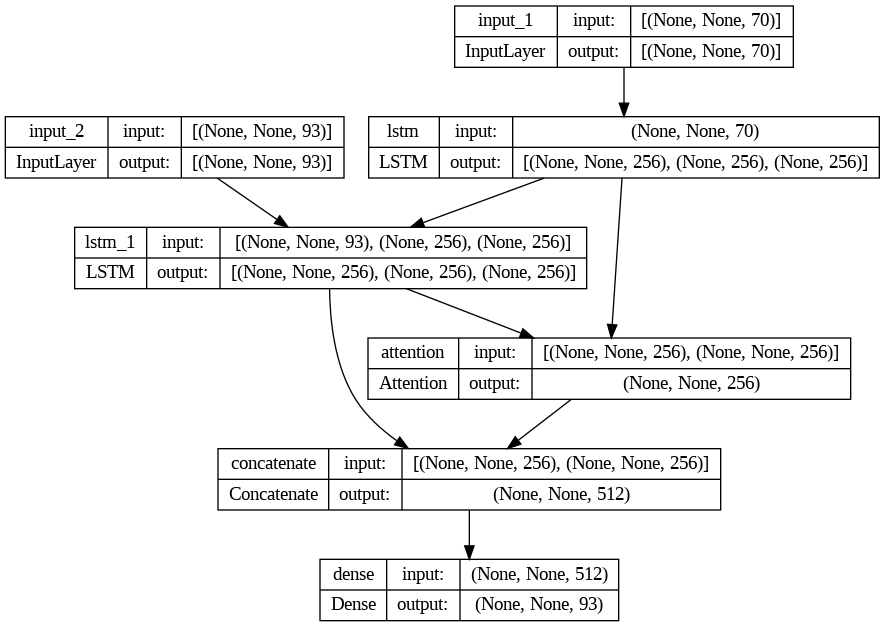

</br>Decoder Model</br>
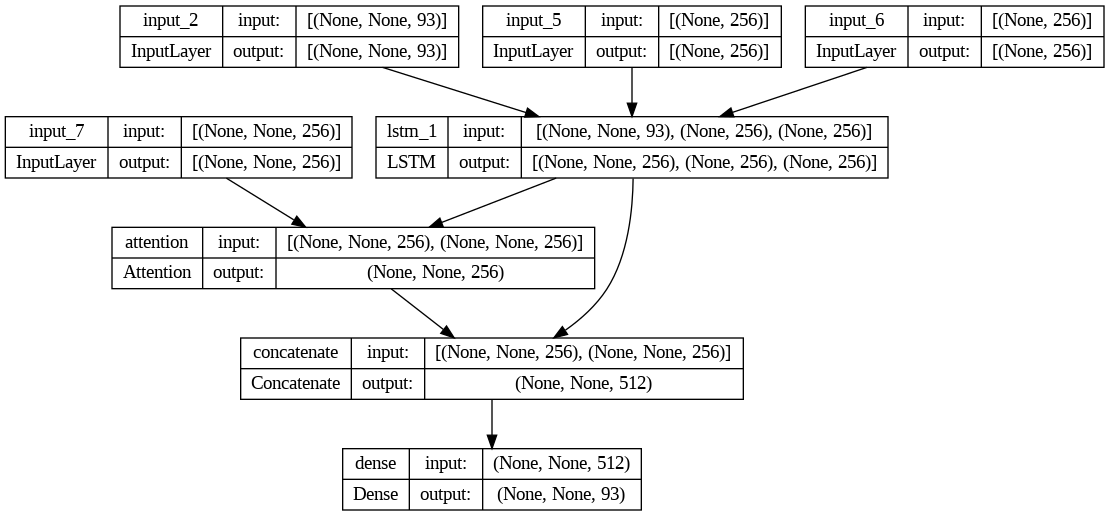

</br>Encoder Model</br>
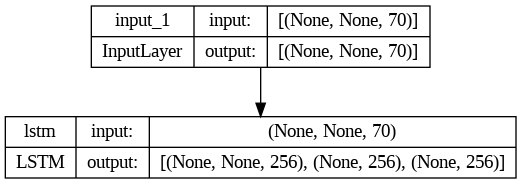

In [10]:
# If model is already in the workspace (not loaded from elsewhere)

encoder_model = keras.Model(encoder_inputs, encoder_states)

decoder_state_input_h = keras.Input(shape=(latent_dim,))
decoder_state_input_c = keras.Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In the following inference part at a time a single character is being decoded (batch_size = 1) and then we are choosing the max probabilty out of the predicted possible next character. This is not really recommended as choosing the maximum probability character at each time step (greedy decoding) can work for some cases, but it has limitations and is not always the best approach (refer notes on beam search).</br></br>
Modified for seq2seq for Attention (check the keras.blog for without attention):</br>
- encoder provides 3 outputs
- decoder takes 3 inputs

In [16]:
# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items()) # dict.items() returns tuple of key : value pairs
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    encoder_op, enc_h, enc_c = encoder_model.predict(input_seq, verbose=0)
    states_value = [enc_h, enc_c]

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index["\t"]] = 1.0

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    # for increasing the batch size just increase the target_seq length target_seq = np.zeros((1, desired_batch_size, num_decoder_tokens))
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [[target_seq] + states_value, encoder_op], verbose=0
        )

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states
        states_value = [h, c]
    return decoded_sentence

In [ ]:
for seq_index in range(20):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index : seq_index + 1] # this is done to keep the dimensions same (3D tensor in this case)
    decoded_sentence = decode_sequence(input_seq)
    print("-")
    print("Input sentence:", input_texts[seq_index])
    print("Decoded sentence:", decoded_sentence)

In [ ]:
seq_index = 0
input_seq = encoder_input_data[seq_index : seq_index + 1] # this is done to keep the dimensions same (3D tensor in this case)
#gives similar o/p to encoder_input_data[seq_index] but using this one dimension is reduced
#print(input_seq)
target_seq = np.zeros((1, 1, num_decoder_tokens))
print(target_seq)

In [17]:
#sentence = input("Enter the sentence in English to translate to French")
sentence = "Where are you?"
sentence_index = []
fin_sentence = np.zeros((1, max_encoder_seq_length, num_encoder_tokens))
for i, char in enumerate(sentence):
    fin_sentence[0, i, input_token_index[char]] = 1.0
fin_sentence[0, i + 1 :, input_token_index[" "]] = 1.0
print(fin_sentence)

[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
   0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

In [18]:
output_sentence = decode_sequence(fin_sentence)
print(f"Input sentence : {sentence}")
print(f"Output sentence : {output_sentence}")

Input sentence : Where are you?
Output sentence : Où es en avante ?



In [30]:
for seq_index in range(1):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index : seq_index + 1] # this is done to keep the dimensions same (3D tensor in this case)
    print(input_seq)

[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0.]
  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0.]
  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

In [38]:
fin_sentence.shape, input_seq.shape

((1, 14, 70), (1, 14, 70))